### WebGL online

In [1]:
# General imports
import os
import sys
import numpy as np
import json
import copy
import cortex
import matplotlib.pyplot as plt

# Personal imports
sys.path.append("{}/../../../../utils".format(os.getcwd()))
from pycortex_utils import draw_cortex, set_pycortex_config_file, load_surface_pycortex, create_colormap

# Inputs
main_dir = '/Users/martinszinte/disks/meso_S/data/'
project_dir = 'amblyo_prf'
subject = 'sub-01'
save_svg = False

# Define analysis parameters
with open('../../../../settings.json') as f:
    json_s = f.read()
    analysis_info = json.loads(json_s)
if subject == 'sub-170k': formats = ['170k']
else: formats = analysis_info['formats']
extensions = analysis_info['extensions']
prf_task_name = analysis_info['prf_task_name']
alpha_range = analysis_info["alpha_range"]
tasks = analysis_info['task_names']

# Maps settings
rsq_idx, ecc_idx, polar_real_idx, polar_imag_idx , size_idx, \
    amp_idx, baseline_idx, x_idx, y_idx = 0, 1, 2, 3, 4, 5, 6, 7, 8
cmap_polar, cmap_uni, cmap_ecc_size = 'hsv', 'Reds', 'Spectral'
col_offset = 1.0/14.0
cmap_steps = 255

# plot scales
rsq_scale = [0, 1]
ecc_scale = [0, 7.5]
size_scale = [0, 7.5]

# Set pycortex db and colormaps
cortex_dir = "{}/{}/derivatives/pp_data/cortex".format(main_dir, project_dir)
set_pycortex_config_file(cortex_dir)

Creating flatmaps...
prf_rsq
prf_polar_255


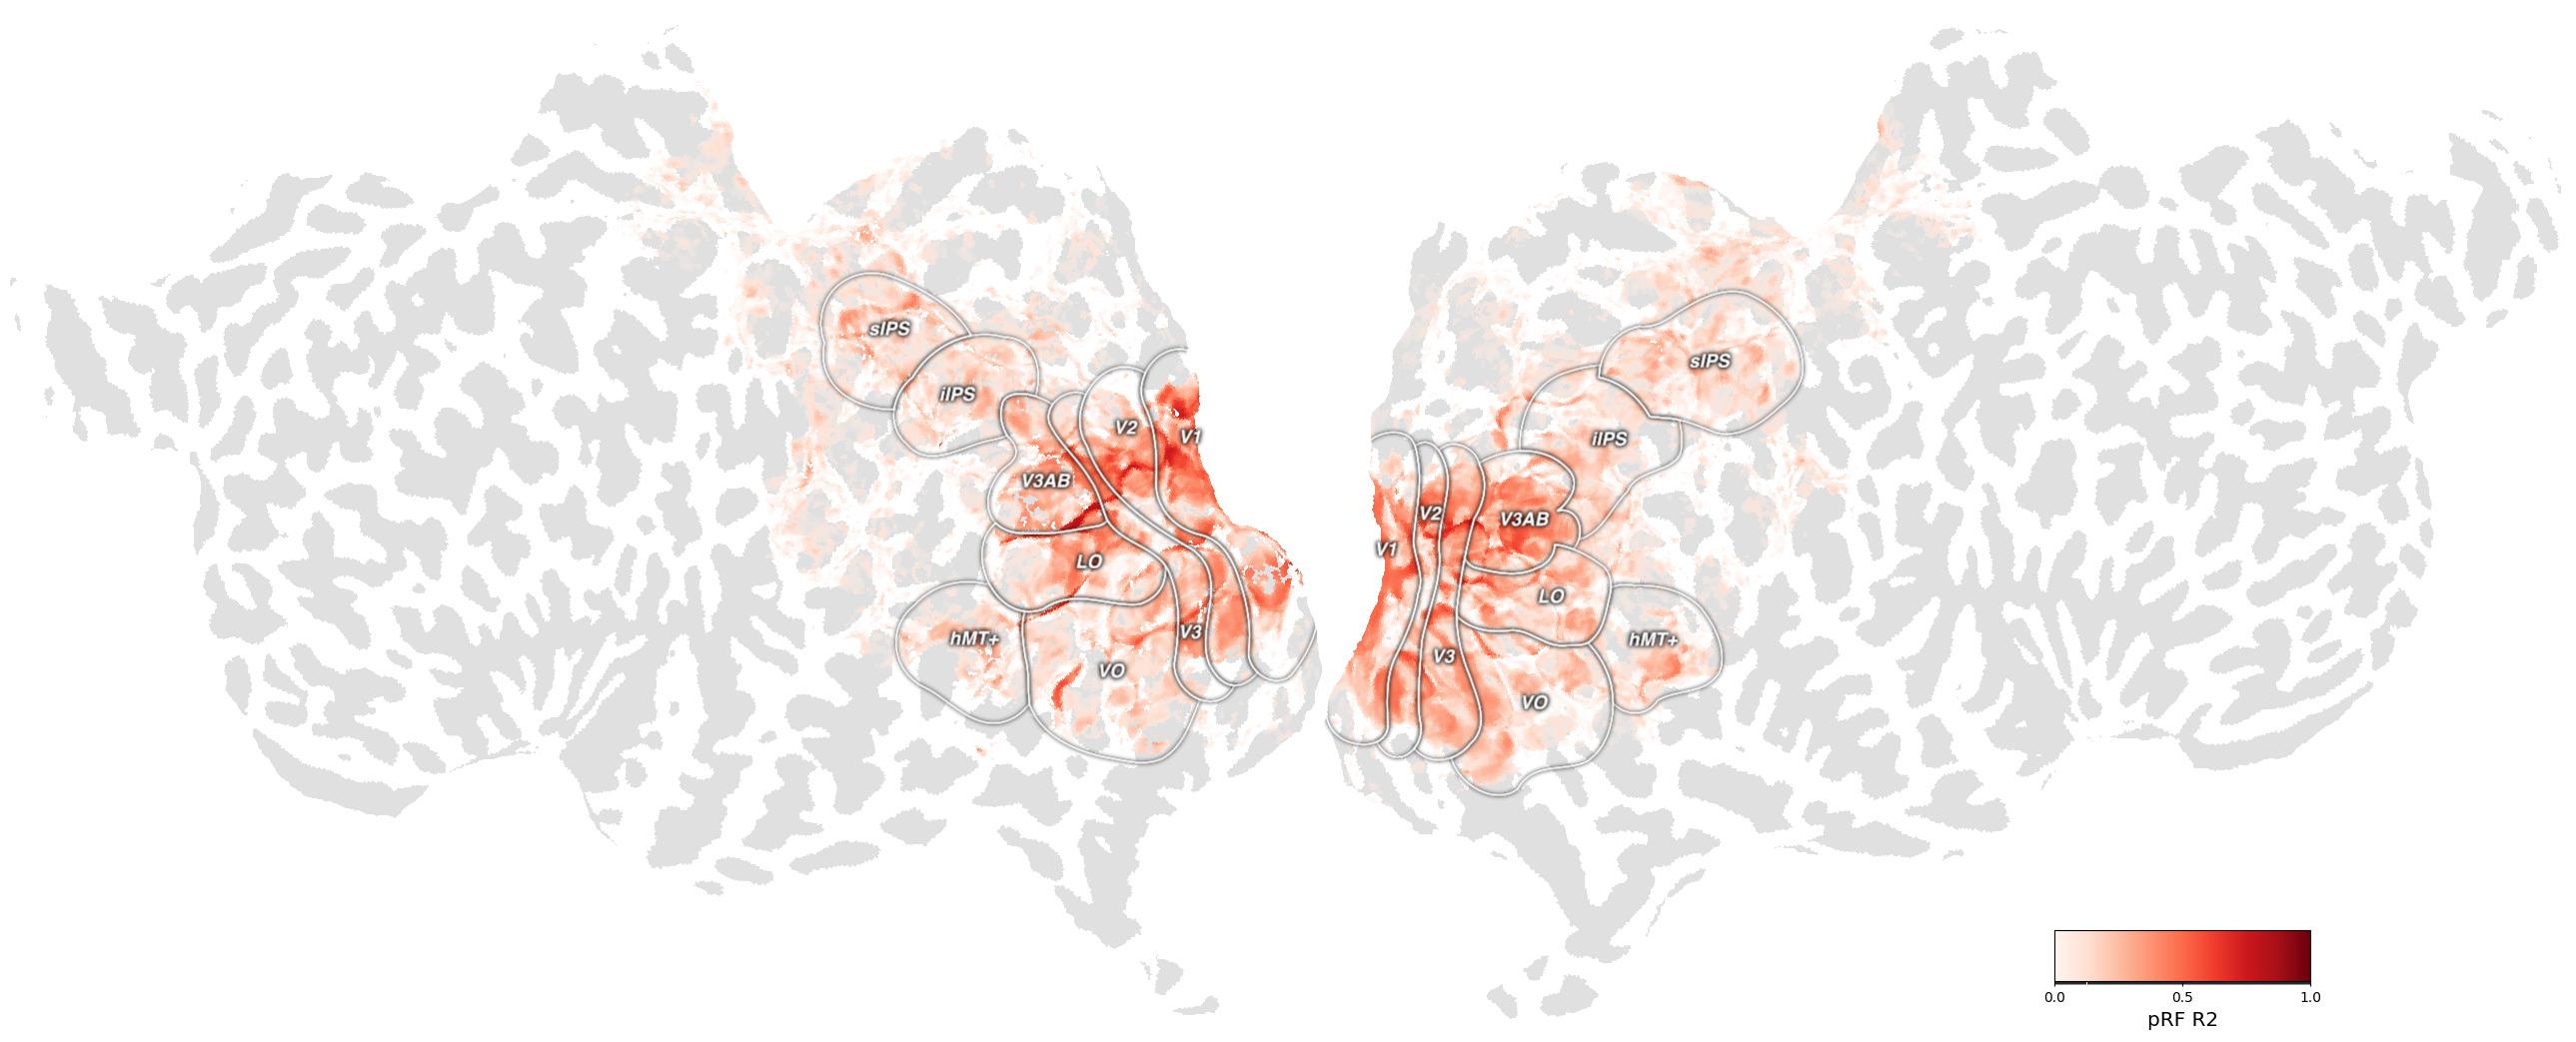

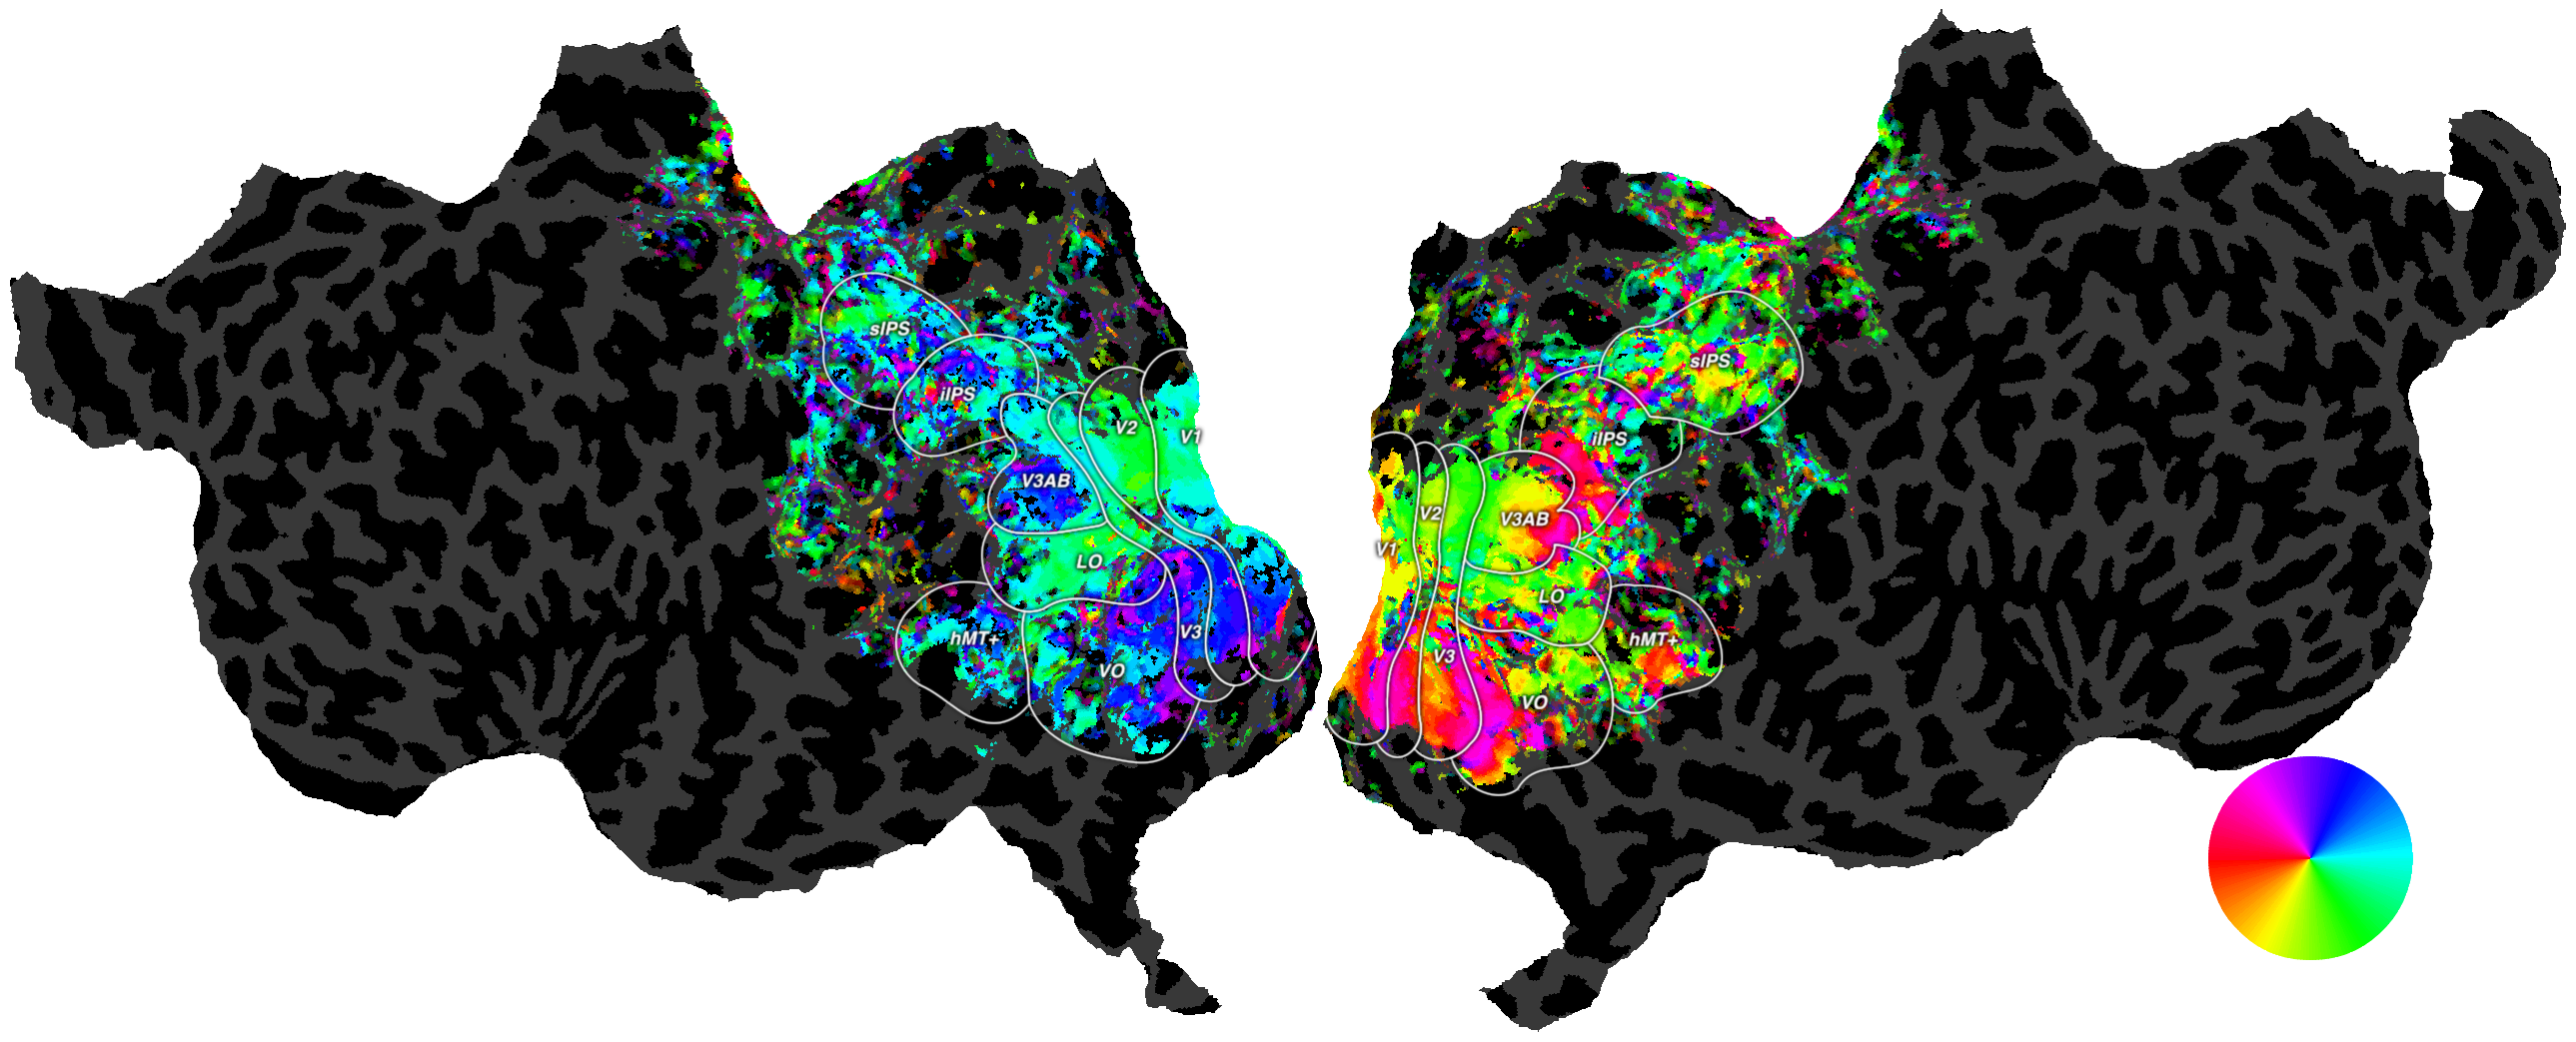

In [2]:
# Create flatmaps
formats = ['fsnative']

for format_, pycortex_subject in zip(formats, [subject, 'sub-170k']):
    # define directories and fn
    prf_dir = "{}/{}/derivatives/pp_data/{}/{}/prf".format(main_dir, project_dir, 
                                                           subject, format_)
    fit_dir = "{}/fit".format(prf_dir)
    prf_deriv_dir = "{}/prf_derivatives".format(prf_dir)
    flatmaps_dir = '{}/pycortex/flatmaps_avg_gauss_gridfit'.format(prf_dir)
    datasets_dir = '{}/pycortex/datasets_avg_gauss_gridfit'.format(prf_dir)
    
    os.makedirs(flatmaps_dir, exist_ok=True)
    os.makedirs(datasets_dir, exist_ok=True)
    
    if format_ == 'fsnative':
        deriv_avg_fn_L = '{}/{}_task-{}_hemi-L_fmriprep_dct_avg_prf-deriv_gauss_gridfit.func.gii'.format(
            prf_deriv_dir, subject, prf_task_name)
        deriv_avg_fn_R = '{}/{}_task-{}_hemi-R_fmriprep_dct_avg_prf-deriv_gauss_gridfit.func.gii'.format(
            prf_deriv_dir, subject, prf_task_name)
        results = load_surface_pycortex(L_fn=deriv_avg_fn_L, 
                                        R_fn=deriv_avg_fn_R)
        deriv_mat = results['data_concat']
        
    elif format_ == '170k':
        deriv_avg_fn = '{}/{}_task-{}_fmriprep_dct_avg_prf-deriv_gauss_gridfit.dtseries.nii'.format(
            prf_deriv_dir, subject, prf_task_name)
        results = load_surface_pycortex(brain_fn=deriv_avg_fn)
        deriv_mat = results['data_concat']
    
    print('Creating flatmaps...')
    
    maps_names = []
    
    # threshold data
    deriv_mat_th = deriv_mat
    amp_down =  deriv_mat_th[amp_idx,...] > 0
    rsqr_th_down = deriv_mat_th[rsq_idx,...] >= analysis_info['rsqr_th']
    size_th_down = deriv_mat_th[size_idx,...] >= analysis_info['size_th'][0]
    size_th_up = deriv_mat_th[size_idx,...] <= analysis_info['size_th'][1]
    ecc_th_down = deriv_mat_th[ecc_idx,...] >= analysis_info['ecc_th'][0]
    ecc_th_up = deriv_mat_th[ecc_idx,...] <= analysis_info['ecc_th'][1]
    all_th = np.array((amp_down, rsqr_th_down, size_th_down, size_th_up, ecc_th_down, ecc_th_up)) 
    deriv_mat[rsq_idx,np.logical_and.reduce(all_th)==False]=0
    
    # r-square
    rsq_data = deriv_mat[rsq_idx,...]
    alpha_range = analysis_info["alpha_range"]
    alpha = (rsq_data - alpha_range[0]) / (alpha_range[1] - alpha_range[0])
    alpha[alpha>1]=1
    param_rsq = {'data': rsq_data,
                 'cmap': cmap_uni,
                 'alpha': alpha,
                 'vmin': rsq_scale[0], 
                 'vmax': rsq_scale[1], 
                 'cbar': 'discrete',
                 'cortex_type': 'VertexRGB',
                 'description': 'Gauss pRF R2',
                 'curv_brightness': 1, 
                 'curv_contrast': 0.25, 
                 'add_roi': save_svg,
                 'cbar_label': 'pRF R2', 
                 'with_labels': True}
    maps_names.append('rsq')
    
    # polar angle
    pol_comp_num = deriv_mat[polar_real_idx,...] + 1j * deriv_mat[polar_imag_idx,...]
    polar_ang = np.angle(pol_comp_num)
    ang_norm = (polar_ang + np.pi) / (np.pi * 2.0)
    ang_norm = np.fmod(ang_norm + col_offset,1)

    param_polar = {'data': ang_norm,
                   'cmap': cmap_polar, 
                   'alpha': alpha, 
                   'vmin': 0,
                   'vmax': 1,
                   'cmap_steps': 255,
                   'cortex_type': 'VertexRGB',
                   'cbar': 'polar', 
                   'col_offset': col_offset, 
                   'description': 'Gaussian pRF polar angle', 
                   'curv_brightness': 0.1, 
                   'curv_contrast': 0.25, 
                   'add_roi': save_svg, 
                   'with_labels': True}
    exec('param_polar_{} = param_polar'.format(int(cmap_steps)))
    exec('maps_names.append("polar_{}")'.format(int(cmap_steps)))

    # draw flatmaps
    volumes = {}
    for maps_name in maps_names:

        # create flatmap
        roi_name = 'prf_{}'.format(maps_name)
        roi_param = {'subject': pycortex_subject, 
                     'roi_name': roi_name}
        print(roi_name)
        exec('param_{}.update(roi_param)'.format(maps_name))
        exec('volume_{maps_name} = draw_cortex(**param_{maps_name})'.format(maps_name=maps_name))

In [3]:
# Webgl for inflated brain pictures
handle = cortex.webgl.show(data=volume_rsq,
                           recache=False,
                           title='bisou'
                          )

Started server on port 31371
